In [1]:
#reference to absolute path where compress folder extracted
absolute_path = %pwd
absolute_path =  absolute_path + "/"

In [2]:
#removing output file so that don't get any error at runtime

import os
try:
    os.remove(f'{absolute_path}{"pack_detector/image2products.json"}')
    os.remove(f'{absolute_path}{"pack_detector/tmp.json"}')
    os.remove(f'{absolute_path}{"pack_detector/metrics.json"}')
    print("All Files are Removed!")
except:
    pass

In [3]:
#All imports are required for this project

import cv2
import itertools
import json
import keras
import numpy as np
import io
import pandas as pd
import tensorflow as tf
import time

from collections import namedtuple, OrderedDict
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from object_detection.utils import dataset_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

from PIL import Image

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [4]:
data_path = absolute_path
shelf_images = f'{absolute_path}{"ShelfImages/"}'
product_images = f'{absolute_path}{"GroceryDataset_part2/ProductImagesFromShelves/"}'
 
PATH_TO_MODEL = f'{absolute_path}{"pack_detector/pack_detector_fg/frozen_inference_graph.pb"}'
PATH_TO_LABELS = f'{absolute_path}{"pack_detector/data/pack.pbtxt"}'
PATH_TO_IMAGES = f'{absolute_path}{"ShelfImages/test/"}'
PATH_TO_DATA = absolute_path
PATH_TO_ANNOTATION = f'{absolute_path}{"pack_detector/annotation.txt"}'
shelf_images_train = f'{absolute_path}{"ShelfImages/train/"}'
shelf_images_test = f'{absolute_path}{"ShelfImages/test/"}'
NUM_CLASSES = 1

img_path = f'{absolute_path}{"ShelfImages/"}'
cropped_path = f'{absolute_path}{"pack_detector/models/ssd_mobilenet_v1/"}'
detector_data_path = f'{absolute_path}{"pack_detector/data/"}'
output_image_path = f'{absolute_path}{"pack_detector/Output/"}'

In [5]:
#defining train and test sets as mentioned in assignment
#And train:set is counts 283:71 
files = [f for f in os.listdir(f'{shelf_images}{"train"}') if f.endswith('JPG')]
train_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
files = [f for f in os.listdir(f'{shelf_images}{"test"}') if f.endswith('JPG')]
test_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
[train_df.count(),test_df.count()]

[file            283
 shelf_id        283
 planogram_id    283
 dtype: int64,
 file            71
 shelf_id        71
 planogram_id    71
 dtype: int64]

In [6]:
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))] 
     for i in range(11) 
     for f in os.listdir(f'{product_images}{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C4_P04_N3_S3_1.JPG,C4_P04,N3_S3_1,0,556,108,224,364,780,472
1,C1_P12_N3_S4_1.JPG,C1_P12,N3_S4_1,0,92,2004,216,332,308,2336
2,C4_P06_N1_S4_1.JPG,C4_P06,N1_S4_1,0,2316,764,216,312,2532,1076
3,C3_P01_N2_S2_1.JPG,C3_P01,N2_S2_1,0,2472,1524,352,584,2824,2108
4,C2_P07_N2_S2_1.JPG,C2_P07,N2_S2_1,0,468,996,244,388,712,1384


In [7]:
shelves = list(set(train_df['shelf_id'].values))

In [8]:
#Brand Recognition

In [9]:
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)

def train(shelf_id): return True
def test(shelf_id): return False
def is_train(shelf_id): return shelf_id in shelves_train

train_df['is_train'] = train_df.shelf_id.apply(train)
test_df['is_train'] = test_df.shelf_id.apply(test)
training_df = train_df.append(test_df)
products_df['is_train'] = products_df.shelf_id.apply(is_train)

In [10]:
#for using neural network, I have to fix the image size. 
num_classes = 10
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [11]:
def resize_image(img):
    fx_ratio = SHAPE_WIDTH / img.shape[1]
    fy_ratio = SHAPE_HEIGHT / img.shape[0]    
    img = cv2.resize(img, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return img[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [12]:
# x - image, y - class, f - is_train flag
x, y, f = [], [], []
for file, is_train in training_df[['file', 'is_train']].values:
    photo_rects = products_df[products_df.file == file]
    rects_data = photo_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    if is_train == True:
        shelf_images = shelf_images_train
    else:
        shelf_images = shelf_images_test
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        img = resize_image(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(img)
        f.append(is_train)
        y.append(category - 1)

In [13]:
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_validation, y_train, y_validation = x[f], x[~f], y[f], y[~f]
x_validation_images = x_validation

In [14]:
# convert y_train and y_validation to one-hot arrays
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)

In [15]:
# normalization
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_train /= 255
x_validation /= 255

In [16]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')

x_train shape: (2119, 120, 80, 3)
y_train shape: (2119, 10)
2119 train samples
625 validation samples


In [17]:
# Building ResNet CNN.
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])



Learning rate:  0.001


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 80, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 80, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 80, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 80, 16)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [19]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

In [20]:
batch_size = 50
epochs = 15
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])


Epoch 1/15
Learning rate:  0.001
43/43 [==============================] - 255s 6s/step - loss: 1.8201 - accuracy: 0.5021 - val_loss: 3.4674 - val_accuracy: 0.1312
Epoch 2/15
Learning rate:  0.001
43/43 [==============================] - 259s 6s/step - loss: 0.9617 - accuracy: 0.7471 - val_loss: 6.8243 - val_accuracy: 0.1232
Epoch 3/15
Learning rate:  0.001
43/43 [==============================] - 262s 6s/step - loss: 0.6791 - accuracy: 0.8429 - val_loss: 2.3942 - val_accuracy: 0.5248
Epoch 4/15
Learning rate:  0.001
43/43 [==============================] - 276s 6s/step - loss: 0.5813 - accuracy: 0.8735 - val_loss: 1.2416 - val_accuracy: 0.7056
Epoch 5/15
Learning rate:  0.001
43/43 [==============================] - 274s 6s/step - loss: 0.4632 - accuracy: 0.9094 - val_loss: 1.2089 - val_accuracy: 0.7328
Epoch 6/15
Learning rate:  0.001
43/43 [==============================] - 278s 6s/step - loss: 0.3981 - accuracy: 0.9363 - val_loss: 1.7069 - val_accuracy: 0.5968
Epoch 7/15
Learning r

In [21]:
model.save(f'{data_path}{"pack_detector/"}{"model.h5"}')
print("Saved model to disk")

model_loaded = load_model(f'{data_path}{"pack_detector/"}{"model.h5"}')
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [22]:
scores = model_loaded.evaluate(x_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

625/625 [==============================] - 16s 26ms/step
Test loss: 0.7220046576499939
Test accuracy: 0.8831999897956848


In [23]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
# Confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_validation, axis=1)
y_validation_predict = model.predict(x_validation)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

In [25]:
y_validation
y_validation_score = []
for row in y_validation_predict:
    ind = np.argmax(row)
    row = np.array((0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0))
    row[ind] = row[ind]+1
    y_validation_score.append(row)
y_validation_score = np.asarray(y_validation_score)

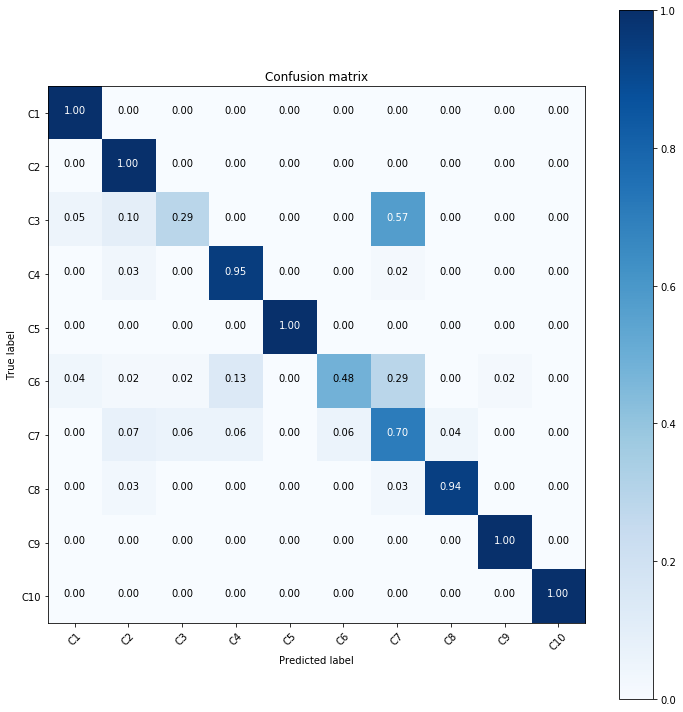

In [26]:
fig = plt.gcf()
fig.set_size_inches(10, 10)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=True)

In [33]:
def writeToJSONFile(path, fileName, data):
    filePathNameWExt = path + '/' + fileName + '.json'
    with open(filePathNameWExt, 'a') as fp:
        json.dump(data, fp, indent=4)

In [77]:
data = classification_report(y_validation, y_validation_score, [0,1,2,3,4,5,6,7,8,9], digits=2, output_dict=True)
writeToJSONFile(f'{data_path}{"pack_detector"}', "tmp", data)

In [78]:
time.sleep(10)
matrix={}
average_precision=[0]*10
with open(f'{data_path}{"pack_detector/"}{"tmp.json"}', 'r') as fp:
    data = json.load(fp)
    for i in range(num_classes):
        average_precision[i] = average_precision_score(y_validation[:, i], y_validation_score[:, i])
        matrix[str(i)]={"mAP": average_precision[i].tolist(), "precision" : data[str(i)]['precision'], "recall" : data[str(i)]['recall']}
    writeToJSONFile(f'{data_path}{"pack_detector"}', "metrics", matrix)

In [36]:
#Products Detection

In [37]:
N_CROP_TRIALS = 6
CROP_SIZE = 1000

In [38]:
def rand_between(s, f):
    if s == f:
        return s
    return np.random.randint(s, f)

In [39]:
train_products, eval_products = [], []
for img_file, is_train in training_df[['file', 'is_train']].values:
    if is_train:
        img_path = shelf_images_train
    else:
        img_path = shelf_images_test
    img = cv2.imread(f'{img_path}{img_file}')
    img_h, img_w, img_c = img.shape
    for n in range(N_CROP_TRIALS):
        c_size = rand_between(300, max(img_h, img_w))
        x0 = rand_between(0, max(0, img_w - c_size))
        y0 = rand_between(0, max(0, img_h - c_size))
        x1 = min(img_w, x0 + c_size)
        y1 = min(img_h, y0 + c_size)
        crop_products = products_df[(products_df.file == img_file) & 
                                 (products_df.xmin > x0) & (products_df.xmax < x1) &
                                 (products_df.ymin > y0) & (products_df.ymax < y1)]
        if len(crop_products) == 0:
            continue
        crop_img_file = f'{img_file[:-4]}{x0}_{y0}_{x1}_{y1}.JPG'
        crop = img[y0:y1, x0:x1]
        h, w, c = crop.shape
        ratio = min(CROP_SIZE/h, CROP_SIZE/w)
        crop = cv2.resize(crop, (0,0), fx=ratio, fy=ratio)
        crop = crop[0:CROP_SIZE, 0:CROP_SIZE]
        h, w, c = crop.shape
        # add crop inner products to train_products or eval_products list
        for xmin, ymin, xmax, ymax in \
                crop_products[['xmin', 'ymin', 'xmax', 'ymax']].values:
            xmin -= x0
            xmax -= x0
            ymin -= y0
            ymax -= y0

            xmin, xmax, ymin, ymax = [int(np.round(e * ratio)) 
                                      for e in [xmin, xmax, ymin, ymax]]
            product = {'filename': crop_img_file, 'class':'pack', 
                       'width':w, 'height':h,
                       'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax}
            if is_train:
                train_products.append(product)
            else:
                eval_products.append(product)
        subpath = ['eval/', 'train/'][is_train]
        cv2.imwrite(f'{cropped_path}{subpath}{crop_img_file}', crop)

In [40]:
train_df = pd.DataFrame(train_products).set_index('filename')
eval_df = pd.DataFrame(eval_products).set_index('filename')

In [41]:
def class_text_to_int(row_label):
    if row_label == 'pack':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) 
            for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [42]:
def convert_to_tf_records(images_path, examples, dst_file):
    writer = tf.io.TFRecordWriter(dst_file)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, images_path)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [43]:
convert_to_tf_records(f'{cropped_path}train/', train_df, f'{detector_data_path}train.record')
convert_to_tf_records(f'{cropped_path}eval/', eval_df, f'{detector_data_path}eval.record')#

In [44]:
# load photos dataframe to get all evaluation images names
testing_df = training_df[~training_df.is_train]
testing_df.head()

,file,shelf_id,planogram_id,is_train
0,C4_P08_N2_S2_1.JPG,C4_P08,N2_S2_1,False
1,C1_P12_N1_S2_1.JPG,C1_P12,N1_S2_1,False
2,C2_P07_N2_S2_1.JPG,C2_P07,N2_S2_1,False
3,C4_P02_N4_S2_1.JPG,C4_P02,N4_S2_1,False
4,C3_P03_N1_S3_1.JPG,C3_P03,N1_S3_1,False


In [45]:
# load frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [46]:
# load categories (we have only 1 category pack)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [47]:
# let's write function that executes detection
def run_inference_for_single_image(image, image_tensor, sess, tensor_dict):
    # Run inference
    expanded_dims = np.expand_dims(image, 0)
    output_dict = sess.run(tensor_dict, feed_dict={image_tensor: expanded_dims})
    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict

In [48]:
# it is useful to be able to run inference not only on the whole image,
# but also on its parts
# cutoff - minimum detection scrore needed to take box
def run_inference_for_image_part(image_tensor, sess, tensor_dict, 
                                 image, cutoff, ax0, ay0, ax1, ay1):
    boxes = []
    im = image[ay0:ay1, ax0:ax1]
    h, w, c = im.shape
    output_dict = run_inference_for_single_image(im, image_tensor, sess, tensor_dict)
    for i in range(100):
        if output_dict['detection_scores'][i] < cutoff:
            break
        y0, x0, y1, x1, score = *output_dict['detection_boxes'][i], \
                                output_dict['detection_scores'][i]
        x0, y0, x1, y1, score = int(x0*w), int(y0*h), \
                                int(x1*w), int(y1*h), \
                                int(score * 100)
        boxes.append((x0+ax0, y0+ay0, x1+ax0, y1+ay0, score))
    return boxes

In [49]:
def run_inference_for_image_part_pcnt(image_tensor, sess, tensor_dict, 
                                 image, cutoff, p_ax0, p_ay0, p_ax1, p_ay1):
    h, w, c = image.shape
    max_x, max_y = w-1, h-1
    return run_inference_for_image_part(
                                image_tensor, sess, tensor_dict, 
                                image, cutoff, 
                                int(p_ax0*max_x), int(p_ay0*max_y), 
                                int(p_ax1*max_x), int(p_ay1*max_y))

In [50]:
# function to display image with bounding boxes
def display_image_with_boxes(image, boxes, file, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for x0, y0, x1, y1, score in boxes:
        image = cv2.rectangle(image, (x0, y0), (x1, y1), (0,255,0), 5)
    if p_x0 != 0 or p_y0 !=0 or p_x1 != 1 or p_y1 != 1:
        h, w, c = image.shape
        max_x, max_y = w-1, h-1
        image = cv2.rectangle(image, 
                              (int(p_x0*max_x), int(p_y0*max_y)), 
                              (int(p_x1*max_x), int(p_y1*max_y)), (0,0,255), 5)
    cv2.imwrite(f'{output_image_path}{file}', image)

In [51]:
# initializations function
def initialize_graph():
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name
                        for op in ops
                        for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes',
                'detection_scores', 'detection_classes',
                'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    return image_tensor, tensor_dict

In [52]:
# function for non-maximum suppression
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return np.array([]).astype("int")

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    sc = boxes[:,4]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(sc)
 
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        #todo fix overlap-contains...
        overlap = (w * h) / area[idxs[:last]]
         
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    
    return boxes[pick].astype("int")

In [53]:
def do_sliding_window_inference_with_nm_suppression(file, cutoff):
    with detection_graph.as_default():
        with tf.Session() as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{PATH_TO_IMAGES}{file}')
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(
                image_tensor, sess, tensor_dict, image, cutoff, 0, 0, 1, 1)
            a = np.array(boxes)
            mean_dx = int(np.mean(a[:,2]-a[:,0]))
            mean_dy = int(np.mean(a[:,3]-a[:,1]))
            step_x, step_y = mean_dx, mean_dy
            window_size = 2*mean_dy
            boxes = []
            y0 = 0
            while y0 < h-1:
                x0 = 0
                while x0 < w-1:
                    x1, y1 = x0 + window_size, y0 + window_size
                    boxes += run_inference_for_image_part(
                        image_tensor, sess, tensor_dict, image, cutoff, 
                        x0, y0, x1, y1)
                    x0 += step_y
                y0 += step_x
            boxes = non_max_suppression(np.array(boxes), 0.5)
            display_image_with_boxes(image, boxes, file)
            return len(boxes)

In [54]:
data ={}
annotation_df = pd.read_csv(f'{PATH_TO_ANNOTATION}', header = None)
for test_file in testing_df.file:
    boxes = do_sliding_window_inference_with_nm_suppression(test_file, 0.7)
    data[test_file] = boxes
writeToJSONFile(f'{data_path}{"pack_detector"}', "image2products", data)    
    

In [67]:
#removing output file so that don't get any error at runtime

import os
try:
    os.remove(f'{absolute_path}{"pack_detector/image2products.json"}')
    os.remove(f'{absolute_path}{"pack_detector/tmp.json"}')
    os.remove(f'{absolute_path}{"pack_detector/metrics.json"}')
    print("All Files are Removed!")
except:
    pass

All Files are Removed!


In [68]:
data = classification_report(y_validation, y_validation_score, [0,1,2,3,4,5,6,7,8,9], digits=2, output_dict=True)
writeToJSONFile(f'{data_path}{"pack_detector"}', "tmp", data)

In [69]:

matrix={}
average_precision=[0]*10
with open(f'{data_path}{"pack_detector/"}{"tmp.json"}', 'r') as fp:
    data = json.load(fp)
    for i in range(num_classes):
        average_precision[i] = average_precision_score(y_validation[:, i], y_validation_score[:, i])
        matrix[str(i)]={"mAP": average_precision[i].tolist(), "precision" : data[str(i)]['precision'], "recall" : data[str(i)]['recall']}
    writeToJSONFile(f'{data_path}{"pack_detector"}', "metrics", matrix)